# Living Coasts Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


### Detecting changes in woody above ground biomass in a selected area

This notebooks allows you to map changes in woody above ground biomass using the global datasets generated by the European Space Agency (ESA) Climate Change Initiative (CCI) Biomass Project (https://climate.esa.int/en/projects/biomass/).  Areas of significant change are identified, with these having no overlap between the histograms.  

## Description 
The notebooks take you through the process of:

1. Selecting an area of interest and extracting above ground biomass data for 8 years (2010 and annually from 2015 to 2021) and the associated standard deviation of the estimates.
2. Viewing the above ground biomass and change maps for comparisons of 2010-2020, 2015-2016, 2016-2017, 2017-2018, 2018-2019, 2019-2020 and 2020-2021).


If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

### Setting up

In [1]:
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")
import display_tools
from display_tools import display_da
from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl


### Selecting your area of interest

In [2]:
# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widget to display coordinates
output = Output(layout={'border': '1px solid black', 'padding': '5px'})

# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    # Ensure consistent ordering of coordinates (assuming lon-lat order)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output:
        output.append_stdout("Coordinates:\n")
        output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    draw_control.clear()
    output.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None

clear_button_draw.on_click(clear_all)
clear_button_manual.on_click(clear_all)

# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output:
            output.append_stdout("Manual Coordinates:\n")
            output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output:
            output.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Tab widget for drawing and manual input
draw_tab = VBox([clear_button_draw, output])
manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output])

tab = Tab()
tab.children = [draw_tab, manual_tab]
tab.set_title(0, 'Draw')
tab.set_title(1, 'Manual Input')

# Add the tab control to the map
tab_control = WidgetControl(widget=tab, position='topright')
m.add_control(tab_control)

# Display the map
display(m)



Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

### Select the time-period (**for DEA land cover only**)

In [3]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


In [4]:
# Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-23.535035, -23.482773)
Lon Range: (150.616188, 150.704079)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-23.535035, -23.482773), 'x': (150.616188, 150.704079), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

#### Access ESA CCI Biomass datasets (2010 and annually from 2015-2021)

In [5]:
# Step 1: Load above ground biomass datasets (SouthEast Queensland)
AGB2010 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2010_AGBcz.tif"
AGB2015 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2015_AGBcz.tif"
AGB2016 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2016_AGBcz.tif"
AGB2017 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2017_AGBcz.tif"
AGB2018 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2018_AGBcz.tif"
AGB2019 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2019_AGBcz.tif"
AGB2020 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2020_AGBcz.tif"
AGB2021 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2021_AGBcz.tif"
SD2010 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2010_SDcz.tif"
SD2015 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2015_SDcz.tif"
SD2016 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2016_SDcz.tif"
SD2017 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2017_SDcz.tif"
SD2018 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2018_SDcz.tif"
SD2019 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2019_SDcz.tif"
SD2020 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2020_SDcz.tif"
SD2021 = "uploads/AGB/S20E150_Qld_SEast/S20E150_2021_SDcz.tif"

# Step 1: Load above ground biomass datasets (South East Western Australia)
#AGB2010 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2010_AGBcz.tif"
#AGB2015 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2015_AGBcz.tif"
#AGB2016 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2016_AGBcz.tif"
#AGB2017 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2017_AGBcz.tif"
#AGB2018 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2018_AGBcz.tif"
#AGB2019 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2019_AGBcz.tif"
#AGB2020 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2020_AGBcz.tif"
#AGB2021 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2021_AGBcz.tif"
#SD2010 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2010_SDcz.tif"
#SD2015 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2015_SDcz.tif"
#SD2016 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2021_SDcz.tif"

# Step 1: Load above ground biomass datasets
#AGB2010 = "../Uploads/AGB/S30E140_Victoria/S30E140_2010_AGBcz.tif"
#AGB2015 = "../Uploads/AGB/S30E140_Victoria/S30E140_2015_AGBcz.tif"
#AGB2016 = "../Uploads/AGB/S30E140_Victoria/S30E140_2016_AGBcz.tif"
#AGB2017 = "../Uploads/AGB/S30E140_Victoria/S30E140_2017_AGBcz.tif"
#AGB2018 = "../Uploads/AGB/S30E140_Victoria/S30E140_2018_AGBcz.tif"
#AGB2019 = "../Uploads/AGB/S30E140_Victoria/S30E140_2019_AGBcz.tif"
#AGB2020 = "../Uploads/AGB/S30E140_Victoria/S30E140_2020_AGBcz.tif"
#AGB2021 = "../Uploads/AGB/S30E140_Victoria/S30E140_2021_AGBcz.tif"
#SD2010 = "../Uploads/AGB/S30E140_Victoria/S30E140_2010_SDcz.tif"
#SD2015 = "../Uploads/AGB/S30E140_Victoria/S30E140_2015_SDcz.tif"
#SD2016 = "../Uploads/AGB/S30E140_Victoria/S30E140_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S30E140_Victoria/S30E140_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S30E140_Victoria/S30E140_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S30E140_Victoria/S30E140_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S30E140_Victoria/S30E140_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S30E140_Victoria/S30E140_2021_SDcz.tif"

# Far North Queensland
#AGB2010 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2010_AGBcz.tif"
#AGB2015 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2015_AGBcz.tif"
#AGB2016 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2016_AGBcz.tif"
#AGB2017 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2017_AGBcz.tif"
#AGB2018 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2018_AGBcz.tif"
#AGB2019 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2019_AGBcz.tif"
#AGB2020 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2020_AGBcz.tif"
#AGB2021 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2021_AGBcz.tif"
#SD2010 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2010_SDcz.tif"
#SD2015 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2015_SDcz.tif"
#SD2016 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2021_SDcz.tif"

# Victoria
# AGB2010 = "../Uploads/AGB/S30E140_Victoria/S30E140_2010_AGBcz.tif"
# AGB2015 = "../Uploads/AGB/S30E140_Victoria/S30E140_2015_AGBcz.tif"
# AGB2016 = "../Uploads/AGB/S30E140_Victoria/S30E140_2016_AGBcz.tif"
# AGB2017 = "../Uploads/AGB/S30E140_Victoria/S30E140_2017_AGBcz.tif"
# AGB2018 = "../Uploads/AGB/S30E140_Victoria/S30E140_2018_AGBcz.tif"
# AGB2019 = "../Uploads/AGB/S30E140_Victoria/S30E140_2019_AGBcz.tif"
# AGB2020 = "../Uploads/AGB/S30E140_Victoria/S30E140_2020_AGBcz.tif"
# AGB2021 = "../Uploads/AGB/S30E140_Victoria/S30E140_2021_AGBcz.tif"
# SD2010 = "../Uploads/AGB/S30E140_Victoria/S30E140_2010_SDcz.tif"
# SD2015 = "../Uploads/AGB/S30E140_Victoria/S30E140_2015_SDcz.tif"
# SD2016 = "../Uploads/AGB/S30E140_Victoria/S30E140_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S30E140_Victoria/S30E140_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S30E140_Victoria/S30E140_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S30E140_Victoria/S30E140_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S30E140_Victoria/S30E140_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S30E140_Victoria/S30E140_2021_SDcz.tif"

# Step 2: Resample to geobox
AGB2010_prj = rio_slurp_xarray(AGB2010,lc.geobox,resampling="nearest")
AGB2015_prj = rio_slurp_xarray(AGB2015,lc.geobox,resampling="nearest")
AGB2016_prj = rio_slurp_xarray(AGB2016,lc.geobox,resampling="nearest")
AGB2017_prj = rio_slurp_xarray(AGB2017,lc.geobox,resampling="nearest")
AGB2018_prj = rio_slurp_xarray(AGB2018,lc.geobox,resampling="nearest")
AGB2019_prj = rio_slurp_xarray(AGB2019,lc.geobox,resampling="nearest")
AGB2020_prj = rio_slurp_xarray(AGB2020,lc.geobox,resampling="nearest")
AGB2021_prj = rio_slurp_xarray(AGB2021,lc.geobox,resampling="nearest")
SD2010_prj = rio_slurp_xarray(SD2010,lc.geobox,resampling="nearest")
SD2015_prj = rio_slurp_xarray(SD2015,lc.geobox,resampling="nearest")
SD2016_prj = rio_slurp_xarray(SD2016,lc.geobox,resampling="nearest")
SD2017_prj = rio_slurp_xarray(SD2017,lc.geobox,resampling="nearest")
SD2018_prj = rio_slurp_xarray(SD2018,lc.geobox,resampling="nearest")
SD2019_prj = rio_slurp_xarray(SD2019,lc.geobox,resampling="nearest")
SD2020_prj = rio_slurp_xarray(SD2020,lc.geobox,resampling="nearest")
SD2021_prj = rio_slurp_xarray(SD2021,lc.geobox,resampling="nearest")

AGB2010_prj = mask_invalid_data(AGB2010_prj)
AGB2015_prj = mask_invalid_data(AGB2015_prj)
AGB2016_prj = mask_invalid_data(AGB2016_prj)
AGB2017_prj = mask_invalid_data(AGB2017_prj)
AGB2018_prj = mask_invalid_data(AGB2018_prj)
AGB2019_prj = mask_invalid_data(AGB2019_prj)
AGB2020_prj = mask_invalid_data(AGB2020_prj)
AGB2021_prj = mask_invalid_data(AGB2021_prj)

AGB2010_prj = AGB2010_prj.where(AGB2010_prj!=0)
AGB2015_prj = AGB2015_prj.where(AGB2015_prj!=0)
AGB2016_prj = AGB2016_prj.where(AGB2016_prj!=0)
AGB2017_prj = AGB2017_prj.where(AGB2017_prj!=0)
AGB2018_prj = AGB2018_prj.where(AGB2018_prj!=0)
AGB2019_prj = AGB2019_prj.where(AGB2019_prj!=0)
AGB2020_prj = AGB2020_prj.where(AGB2020_prj!=0)
AGB2021_prj = AGB2021_prj.where(AGB2021_prj!=0)

SD2010_prj = mask_invalid_data(SD2010_prj)
SD2015_prj = mask_invalid_data(SD2015_prj)
SD2016_prj = mask_invalid_data(SD2016_prj)
SD2017_prj = mask_invalid_data(SD2017_prj)
SD2018_prj = mask_invalid_data(SD2018_prj)
SD2019_prj = mask_invalid_data(SD2019_prj)
SD2020_prj = mask_invalid_data(SD2020_prj)
SD2021_prj = mask_invalid_data(SD2021_prj)

# Step 3: Generate uncertainties based on stock differences
AGB = AGB2010_prj.to_dataset(name="AGB2010")
AGB["AGB2015"] = AGB2017_prj
AGB["AGB2016"] = AGB2018_prj
AGB["AGB2017"] = AGB2017_prj
AGB["AGB2018"] = AGB2018_prj
AGB["AGB2019"] = AGB2019_prj
AGB["AGB2020"] = AGB2020_prj
AGB["AGB2021"] = AGB2021_prj

diff2010_2020=(AGB.AGB2021.fillna(0)-AGB.AGB2010.fillna(0))
diff2010_2015=(AGB.AGB2015.fillna(0)-AGB.AGB2010.fillna(0))
diff2015_2016=(AGB.AGB2016.fillna(0)-AGB.AGB2015.fillna(0))
diff2016_2017=(AGB.AGB2017.fillna(0)-AGB.AGB2016.fillna(0))
diff2017_2018=(AGB.AGB2018.fillna(0)-AGB.AGB2017.fillna(0))
diff2018_2019=(AGB.AGB2019.fillna(0)-AGB.AGB2018.fillna(0))
diff2019_2020=(AGB.AGB2020.fillna(0)-AGB.AGB2019.fillna(0))
diff2020_2021=(AGB.AGB2021.fillna(0)-AGB.AGB2020.fillna(0))
diff2017_2020=(AGB.AGB2021.fillna(0)-AGB.AGB2017.fillna(0))

diff_biomass = diff2010_2020.where(diff2010_2020!=0).to_dataset(name="d2010_2020")
diff_biomass["d2010_2015"] = diff2010_2015.where(diff2010_2015!=0)
diff_biomass["d2015_2016"] = diff2015_2016.where(diff2015_2016!=0)
diff_biomass["d2016_2017"] = diff2016_2017.where(diff2016_2017!=0)
diff_biomass["d2017_2018"] = diff2017_2018.where(diff2017_2018!=0)
diff_biomass["d2018_2019"] = diff2018_2019.where(diff2018_2019!=0)
diff_biomass["d2019_2020"] = diff2019_2020.where(diff2019_2020!=0)
diff_biomass["d2020_2021"] = diff2020_2021.where(diff2020_2021!=0)
diff_biomass["d2017_2020"] = diff2017_2020.where(diff2017_2020!=0)

SD = SD2010_prj.to_dataset(name="SD2010")
SD["SD2015"] = SD2015_prj
SD["SD2016"] = SD2016_prj
SD["SD2017"] = SD2017_prj
SD["SD2018"] = SD2018_prj
SD["SD2019"] = SD2019_prj
SD["SD2020"] = SD2020_prj
SD["SD2021"] = SD2021_prj

del AGB2010, AGB2015, AGB2016, AGB2017, AGB2018, AGB2019, AGB2020, AGB2021, SD2010, SD2015, SD2016, SD2017, SD2018, SD2019, SD2020, SD2021

AGB2010_Min = AGB.AGB2010-SD.SD2010
AGB2010_Max = AGB.AGB2010+SD.SD2010
AGB2015_Min = AGB.AGB2015-SD.SD2015
AGB2015_Max = AGB.AGB2015+SD.SD2015
AGB2016_Min = AGB.AGB2016-SD.SD2016
AGB2016_Max = AGB.AGB2016+SD.SD2016
AGB2017_Min = AGB.AGB2017-SD.SD2017
AGB2017_Max = AGB.AGB2017+SD.SD2017
AGB2018_Min = AGB.AGB2018-SD.SD2018
AGB2018_Max = AGB.AGB2018+SD.SD2018
AGB2019_Min = AGB.AGB2019-SD.SD2019
AGB2019_Max = AGB.AGB2019+SD.SD2019
AGB2020_Min = AGB.AGB2020-SD.SD2020
AGB2020_Max = AGB.AGB2020+SD.SD2020
AGB2021_Min = AGB.AGB2021-SD.SD2021
AGB2021_Max = AGB.AGB2021+SD.SD2021

min_biomass = AGB2010_Min.to_dataset(name="AGB2010_Min")
min_biomass["AGB2015_Min"] = AGB2015_Min
min_biomass["AGB2016_Min"] = AGB2016_Min
min_biomass["AGB2017_Min"] = AGB2017_Min
min_biomass["AGB2018_Min"] = AGB2018_Min
min_biomass["AGB2019_Min"] = AGB2019_Min
min_biomass["AGB2020_Min"] = AGB2020_Min
min_biomass["AGB2021_Min"] = AGB2021_Min

del AGB2010_Min, AGB2015_Min, AGB2016_Min, AGB2017_Min, AGB2018_Min, AGB2019_Min, AGB2020_Min,  AGB2021_Min

max_biomass = AGB2010_Max.to_dataset(name="AGB2010_Max")
max_biomass["AGB2015_Max"] = AGB2015_Max
max_biomass["AGB2016_Max"] = AGB2016_Max
max_biomass["AGB2017_Max"] = AGB2017_Max
max_biomass["AGB2018_Max"] = AGB2018_Max
max_biomass["AGB2019_Max"] = AGB2019_Max
max_biomass["AGB2020_Max"] = AGB2020_Max
max_biomass["AGB2021_Max"] = AGB2021_Max

del AGB2010_Max, AGB2015_Max, AGB2016_Max, AGB2017_Max, AGB2018_Max, AGB2019_Max, AGB2020_Max, AGB2021_Max

cond_dec_2010_2020 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2010_2015 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2015_Max.fillna(0)
cond_dec_2015_2016 = min_biomass.AGB2015_Min.fillna(0) > max_biomass.AGB2016_Max.fillna(0)
cond_dec_2016_2017 = min_biomass.AGB2016_Min.fillna(0) > max_biomass.AGB2017_Max.fillna(0)
cond_dec_2017_2018 = min_biomass.AGB2017_Min.fillna(0) > max_biomass.AGB2018_Max.fillna(0)
cond_dec_2018_2019 = min_biomass.AGB2018_Min.fillna(0) > max_biomass.AGB2019_Max.fillna(0)
cond_dec_2019_2020 = min_biomass.AGB2019_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2020_2021 = min_biomass.AGB2020_Min.fillna(0) > max_biomass.AGB2021_Max.fillna(0)
cond_dec_2017_2020 = min_biomass.AGB2015_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)

cond_inc_2010_2020 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2010_2015 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2015_Min.fillna(0)
cond_inc_2015_2016 = max_biomass.AGB2015_Max.fillna(0) < min_biomass.AGB2016_Min.fillna(0)
cond_inc_2016_2017 = max_biomass.AGB2016_Max.fillna(0) < min_biomass.AGB2017_Min.fillna(0)
cond_inc_2017_2018 = max_biomass.AGB2017_Max.fillna(0) < min_biomass.AGB2018_Min.fillna(0)
cond_inc_2018_2019 = max_biomass.AGB2018_Max.fillna(0) < min_biomass.AGB2019_Min.fillna(0)
cond_inc_2019_2020 = max_biomass.AGB2019_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2020_2021 = max_biomass.AGB2020_Max.fillna(0) < min_biomass.AGB2021_Min.fillna(0)
cond_inc_2017_2020 = max_biomass.AGB2015_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)

agb_sc = cond_dec_2010_2020.to_dataset(name="cond_dec_2010_2020") 
agb_sc["cond_dec_2010_2015"] = cond_dec_2010_2015
agb_sc["cond_dec_2015_2016"] = cond_dec_2015_2016
agb_sc["cond_dec_2016_2017"] = cond_dec_2016_2017
agb_sc["cond_dec_2017_2018"] = cond_dec_2017_2018
agb_sc["cond_dec_2018_2019"] = cond_dec_2018_2019 
agb_sc["cond_dec_2019_2020"] = cond_dec_2019_2020 
agb_sc["cond_dec_2020_2021"] = cond_dec_2020_2021 
agb_sc["cond_dec_2017_2020"] = cond_dec_2017_2020 

agb_sc = cond_inc_2010_2020.to_dataset(name="cond_inc_2010_2020") 
agb_sc["cond_inc_2010_2015"] = cond_inc_2010_2015
agb_sc["cond_inc_2015_2016"] = cond_inc_2015_2016
agb_sc["cond_inc_2016_2017"] = cond_inc_2016_2017
agb_sc["cond_inc_2017_2018"] = cond_inc_2017_2018
agb_sc["cond_inc_2018_2019"] = cond_inc_2018_2019 
agb_sc["cond_inc_2019_2020"] = cond_inc_2019_2020 
agb_sc["cond_inc_2020_2021"] = cond_inc_2020_2021 
agb_sc["cond_inc_2017_2020"] = cond_inc_2017_2020 

### View datasets of biomass and biomass change for all years

In [6]:
bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))

[49 100]


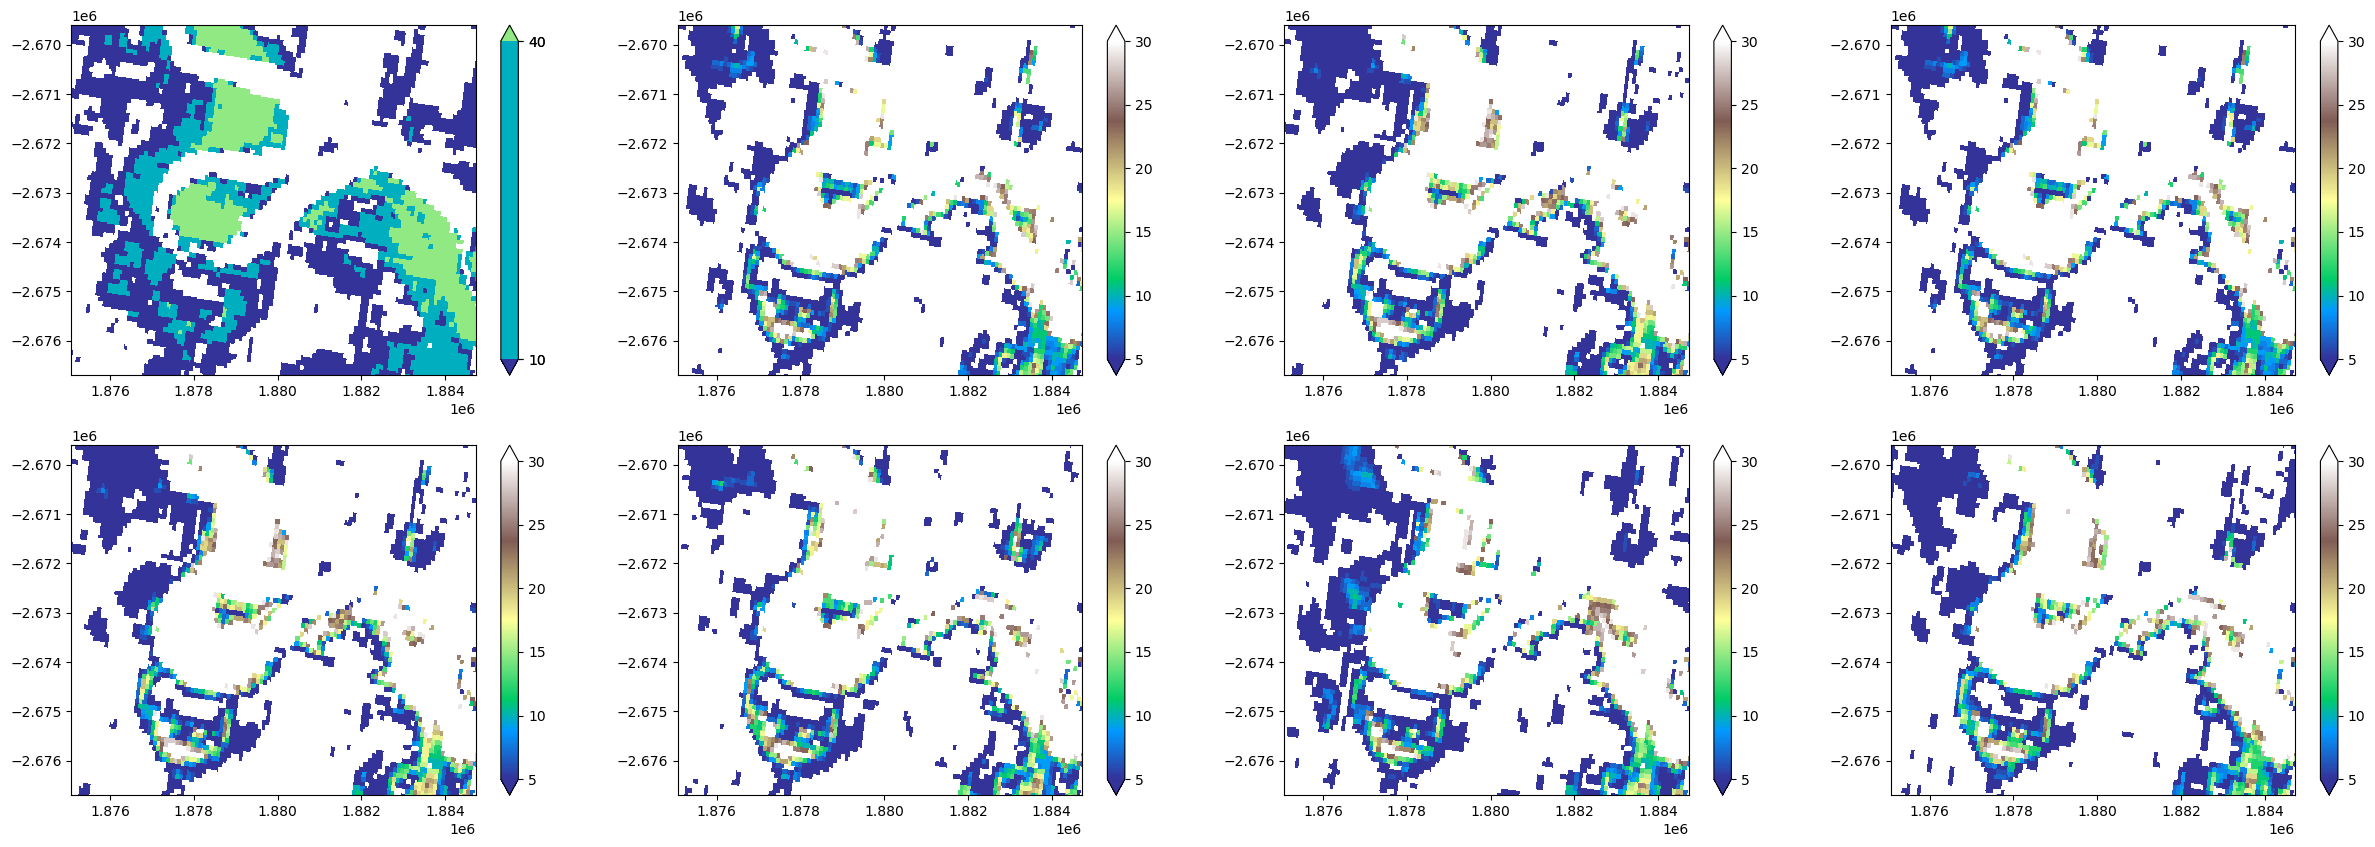

In [7]:
AGB_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB.AGB2010.plot(ax=axs[0,0], cmap='terrain', norm=norm, add_labels=False)
AGB.AGB2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)

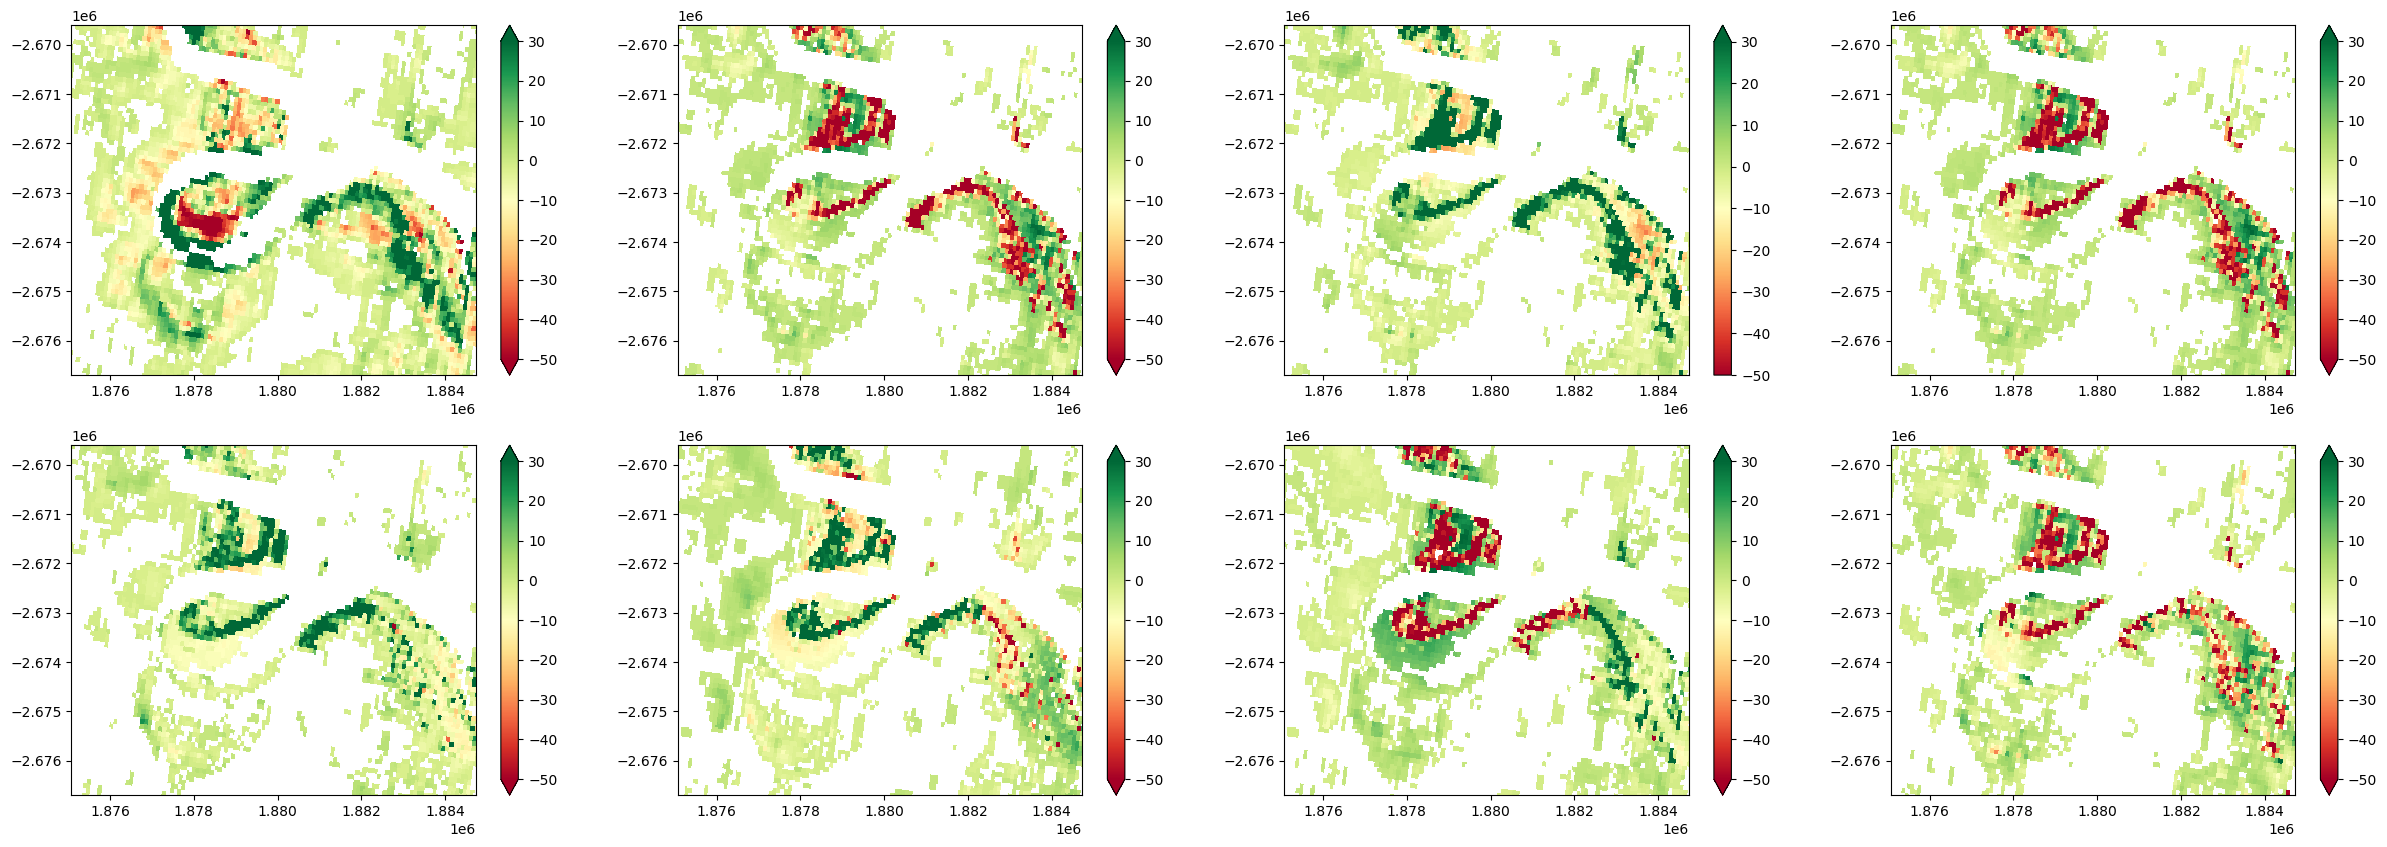

In [8]:
AGB_diff_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
diff_biomass.d2010_2020.plot(ax=axs[0,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2015_2016.plot(ax=axs[0,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2016_2017.plot(ax=axs[0,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2017_2018.plot(ax=axs[0,3], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2018_2019.plot(ax=axs[1,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2019_2020.plot(ax=axs[1,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2020_2021.plot(ax=axs[1,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2017_2020.plot(ax=axs[1,3], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)

### View datasets of biomass and biomass change for selected years

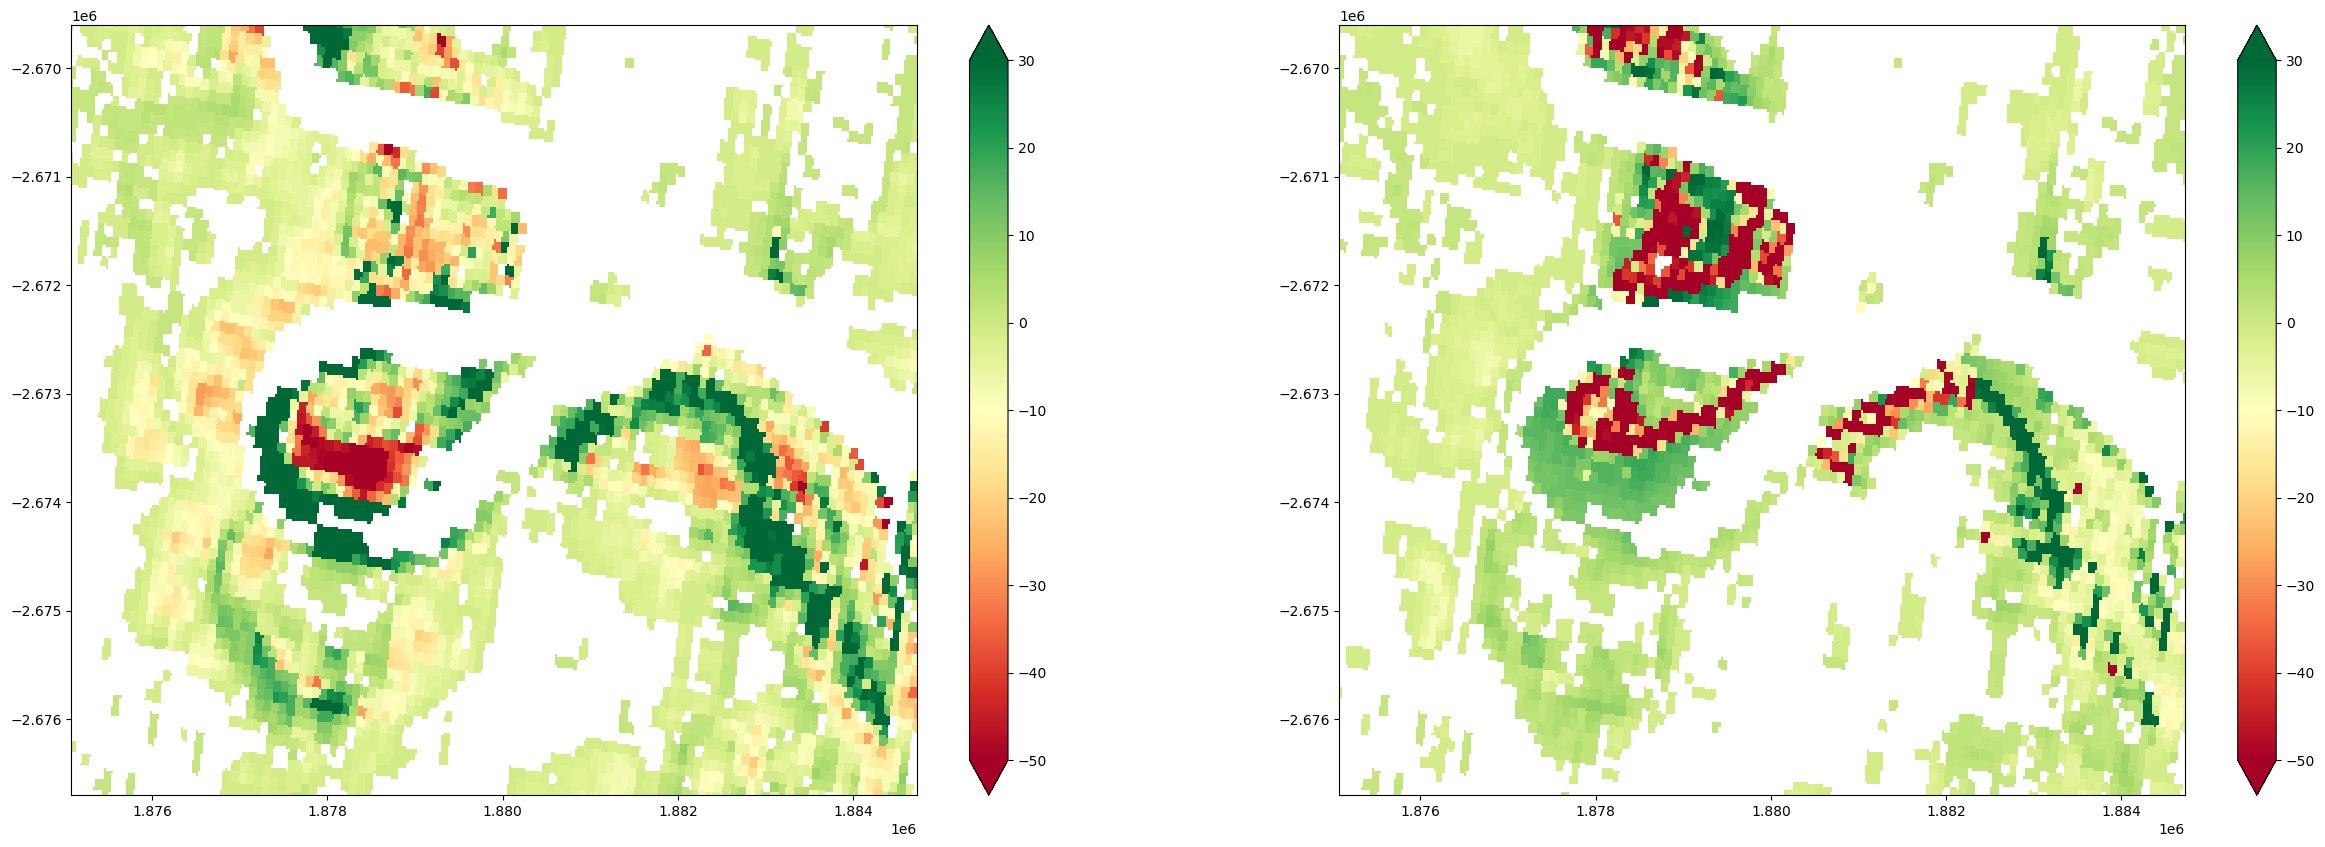

In [9]:
AGB_diff_fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(30, 10))
diff_biomass.d2010_2020.plot(ax=axs[0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2020_2021.plot(ax=axs[1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)


### View maps of DEA land cover for the same area

In [10]:
#  Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`